In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.pipeline import Pipeline, FeatureUnion

#Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import export_graphviz

#Transformations (Dimensional reduction)
from sklearn.decomposition import PCA, FastICA

#Metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split, learning_curve

from random import randint

#Ensamble methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

#Oversampling algorithms
from imblearn.over_sampling import SMOTE, ADASYN
from learning_c import plot_learning_curve

%matplotlib inline

### Best found classifiers 

OS: Using an oversampling technique (adasyn or smote)
- Naive Bayes
- (OS)Lineal discriminant Analysis using  hyperparameters:
  - least squares function 'lsqr'
- (OS)Logistic regresion using  hyperparameters:
  - solver    newton-cg
  - param_C   low regularization     0.7!
- Decision Trees
  - param_criterion                            gini,(os)entropy
  - param_min_weight_fraction_leaf                   0
  - param_max_features                            None
  - param_class_weight                {0: 0.2, 1: 1.0}
  - param_max_depth                                  5
- SVC
  
#### can i use cv insede a piline?
- so try PCA, ICA Etc 
- with and without OS

- also dadboost and random forests

In [45]:
data_iono = pd.read_csv("events_morefeatures.csv",index_col=0)
print "Features: ",data_iono.columns

metadata = ['prn','network','STATIONS','PAIRS', 'ID','YEAR', 'DAY','TIME' ]
labels = ['BIN_LABEL' 'LABEL']
X = data_iono[['A_index', 'C_flare', 'K_index', 'N_PAIRS', 'N_STATIONS',
       'kurtosis_delay', 'kurtosis_grad', 'max_elevation', 'max_grad',
       'max_phase_delay', 'mean_code_delay', 'mean_elevation', 'mean_grad',
       'mean_phase_delay', 'min_elevation', 'min_grad', 'min_phase_delay',
       'mse', 'new_regions', 'radio_flux', 'std_grad', 'std_phase',
       'sunsplot_number', 'sunspot_area', 'bucket_grad',
       'bucket_grad_mean', 'k_index_bucket', 'elev_min_bucket',
       'elev_mean_bucket', 'elev_max_bucket', 'grad_elev']]

print "Dataset shape: ",X.shape
y_bin, y_classes = data_iono.BIN_LABEL, data_iono.LABEL

Features:  Index([u'A_index', u'C_flare', u'K_index', u'N_PAIRS', u'N_STATIONS',
       u'kurtosis_delay', u'kurtosis_grad', u'max_elevation', u'max_grad',
       u'max_phase_delay', u'mean_code_delay', u'mean_elevation', u'mean_grad',
       u'mean_phase_delay', u'min_elevation', u'min_grad', u'min_phase_delay',
       u'mse', u'new_regions', u'radio_flux', u'std_grad', u'std_phase',
       u'sunsplot_number', u'sunspot_area', u'bucket_grad',
       u'bucket_grad_mean', u'k_index_bucket', u'elev_min_bucket',
       u'elev_mean_bucket', u'elev_max_bucket', u'grad_elev', u'BIN_LABEL',
       u'LABEL', u'prn', u'network', u'STATIONS', u'PAIRS', u'ID', u'YEAR',
       u'DAY', u'TIME'],
      dtype='object')
Dataset shape:  (1048, 31)


In [49]:
#split !
X_train, X_test, y_train, y_test = train_test_split(X, y_bin,train_size=0.75, test_size=0.25, random_state=randint(1,100), stratify= y_bin)

### Naive Bayes

A transformer is just an object that responds to fit, transform, and fit_transform

In [53]:
class AdasynTransformer(ADASYN):
    def fit(self):
        return None
    def transform(self, X, y = None,**transform_params):
        return self.fit_sample(X, y)

class SmoteTransformer(SMOTE):
    def fit(self):
        return None
    def transform(self, X, y = None,**transform_params):
        return self.fit_sample(X, y)
   

ada = AdasynTransformer()
nX,nY = ada.transform(X,y_bin)
print nX.shape

smo = SmoteTransformer()
nX,nY = smo.transform(X,y_bin)
print nX.shape

In [57]:
pipeline = Pipeline([
  #('Oversample_ada', AdasynTransformer()),
  ('PCA', PCA(n_components=5)),
  ('classifier',GaussianNB())
])

In [61]:
pipeline.fit(X_train,y_train)
y_predict = pipeline.predict(X_test)
score = fbeta_score(y_test,y_predict,beta=2)
print score

0.648148148148


In [ ]:
pipeline = Pipeline([
  ('extract_essays', EssayExractor()),
  ('features', FeatureUnion([
    ('ngram_tf_idf', Pipeline([
      ('counts', CountVectorizer()),
      ('tf_idf', TfidfTransformer())
    ])),
    ('essay_length', LengthTransformer()),
    ('misspellings', MispellingCountTransformer())
  ])),
  ('classifier', MultinomialNB())
])

### Decission Trees

*paint them !

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

Two families of ensemble methods are usually distinguished:


In **averaging methods**, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.
Examples: Bagging methods, Forests of randomized trees, ...


By contrast, in **boosting methods**, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.
Examples: AdaBoost, Gradient Tree Boosting, ...

-----------------------------------------------------------------
# Bagging methods

> This methods form a class of algorithms which build several instances of a black-box estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction.  **A way to reduce the variance of a base estimator** by introducing randomization into its construction procedure and then making an ensemble out of it. As **they provide a way to reduce overfitting**s, bagging methods work best with strong and complex models (e.g., fully developed decision trees)

When samples are drawn with replacement, then the method is known as Bagging [B1996].

 - Forests of randomized trees
   - *Random forests:*
   each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset of the features. As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.
   

### RandomForest

-----------------------------------------------------
   
# Boosting methods
- **Boosting **
 - *Adaboost:* The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights $w_1, w_2, ..., w_N$ to each of the training samples. Initially, those weights are all set to $w_i = 1/N$, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequenc.
 
  - *Gradient Tree Boosting  (GBRT)* is a generalization of boosting to arbitrary differentiable loss functions. GBRT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems. Gradient Tree Boosting models are used in a variety of areas including Web search ranking and ecology. The advantages of GBRT are:
   - Natural handling of data of mixed type (= heterogeneous features)
   - Predictive power
   - Robustness to outliers in output space (via robust loss functions)
 
 The disadvantages of GBRT are:
   - Scalability, due to the sequential nature of boosting it can hardly be parallelized.

## Adaboost


************** RECALL  ******************
TPR-Recall: 0.87 (+/- 0.07)
Scores CV:  [ 0.85781991  0.90995261  0.82938389] 


Test
Score on test:  0.659574468085

************** FALSE NEGATIVA RATE  ******************
FNR: 0.10 (+/- 0.03)
Scores CV:  [ 0.0744186   0.10697674  0.10747664] 


Test
Score on test:  0.106976744186

************** F1 SCORE ******************
F1: 0.88 (+/- 0.04)
Scores cv:  [ 0.8872549   0.90140845  0.85574572] 


Test
Score on test:  0.613861386139

************** ACCURACY ******************
ACC: 0.88 (+/- 0.03)
Scores cv:  [ 0.89201878  0.90140845  0.86117647] 


Test
Score on test:  0.851145038168

************** PRECISION ******************
PRESC: 0.90 (+/- 0.03)
Scores cv:  [ 0.91878173  0.89302326  0.88383838] 

Score on test:  0.574074074074
Learning Curves


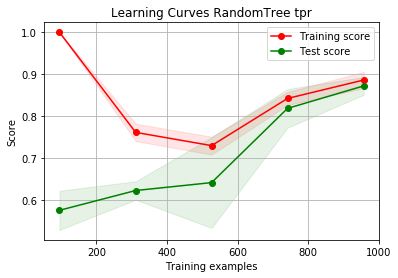

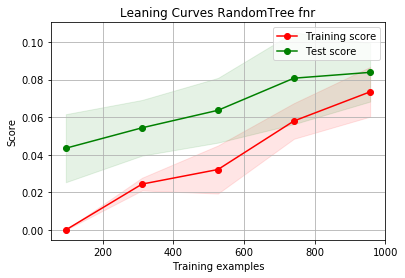

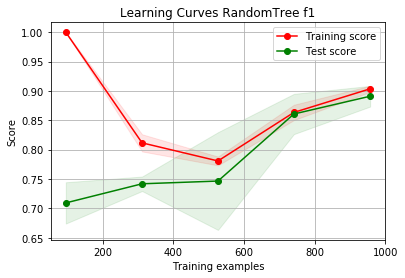

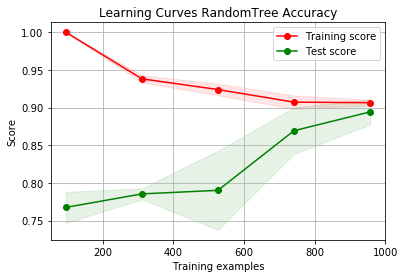

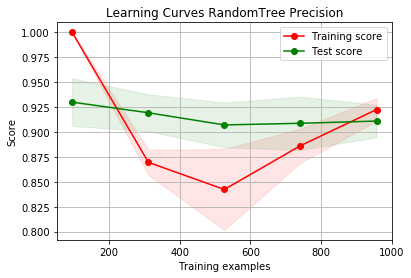

In [34]:
clf = AdaBoostClassifier(n_estimators=10)
cv = StratifiedKFold(n_splits=3, random_state=randint(1,100), shuffle=True)

#recall
print "\n************** RECALL  ******************"
scores = cross_val_score(clf, X_atrain, y_atrain, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores CV: ",scores,"\n"

print "\nTest"
clf.fit(X_atrain, y_atrain)
y_pred = clf.predict(X_test)
score_test = recall_score(y_test, y_pred)
print "Score on test: ",score_test

#fnr
print "\n************** FALSE NEGATIVA RATE  ******************"
scores = cross_val_score(clf, X_atrain, y_atrain, cv=cv, scoring=fnr_scorer )
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores CV: ",scores,"\n"

print "\nTest"
clf.fit(X_atrain, y_atrain)
y_pred = clf.predict(X_test)
score_test = fnr_score(y_test, y_pred)
print "Score on test: ",score_test

#f1
print "\n************** F1 SCORE ******************"
scores = cross_val_score(clf, X_atrain, y_atrain, cv=cv, scoring='f1')
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores cv: ",scores,"\n"

print "\nTest"
clf.fit(X_atrain, y_atrain)
y_pred = clf.predict(X_test)
score_test = f1_score(y_test, y_pred)
print "Score on test: ",score_test

#accuracy
print "\n************** ACCURACY ******************"
scores = cross_val_score(clf, X_atrain, y_atrain, cv=cv, scoring='accuracy')
print("ACC: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores cv: ",scores,"\n"

print "\nTest"
clf.fit(X_atrain, y_atrain)
y_pred = clf.predict(X_test)
score_test = accuracy_score(y_test, y_pred)
print "Score on test: ",score_test

#precision
print "\n************** PRECISION ******************"
scores = cross_val_score(clf, X_atrain, y_atrain, cv=cv, scoring='precision')
print("PRESC: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores cv: ",scores,"\n"

clf.fit(X_atrain, y_atrain)
y_pred = clf.predict(X_test)
score_test = precision_score(y_test, y_pred)
print "Score on test: ",score_test #muchis falsos positivos?

####################################################################
print "Learning Curves" 

t1 = "Learning Curves RandomTree tpr"
t2 = "Leaning Curves RandomTree fnr"
t3 = "Learning Curves RandomTree f1"
t4 = "Learning Curves RandomTree Accuracy"
t5 = "Learning Curves RandomTree Precision"

cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)

plot_learning_curve(clf, t1, X_atrain, y_atrain,  cv=cv, n_jobs=4, scoring = 'recall') 
plot_learning_curve(clf, t2, X_atrain, y_atrain,  cv=cv, n_jobs=4, scoring= fnr_scorer) 
plot_learning_curve(clf, t3, X_atrain, y_atrain,  cv=cv, n_jobs=4, scoring= 'f1') 
plot_learning_curve(clf, t4, X_atrain, y_atrain,  cv=cv, n_jobs=4, scoring= 'accuracy') 
plot_learning_curve(clf, t5, X_atrain, y_atrain,  cv=cv, n_jobs=4, scoring= 'precision')
plt.show()


In [3]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)                 


0.91300000000000003